In [1]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# load the balanced dataset, not the unbalanced one

shuffled_df = pd.read_csv("bal_shuffled_df.csv", index_col=0)

In [3]:
# define list of texts and list of labels

texts = shuffled_df["Body"].tolist()  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = shuffled_df["Category"].tolist()  # list of label ids

In [4]:
# clean html tags from texts

import re

def remove_html_tags(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

cleantexts = []

for i in range(len(texts)):
    para = str(texts[i])
    # print(para)
    # print(type(para))
    cleantext = remove_html_tags(para)
    cleantexts.append(cleantext)
    
    

In [5]:
# set up list of categories to map labels to

labels_index = {}

categories = ["ai", 
              "batterytech", 
              "blackswans", 
              "blockchain", 
              "carboneradication", 
              "cpr_articles", 
              "digitalads", 
              "digitalcurrency",
              "digitalhealth", 
              "educationtech", 
              "financialservices", 
              "internetofthings", 
              "property", 
              "sharingeconomy"]

cleanlabels = []

for name in categories:
    label_id = len(labels_index)
    labels_index[name] = label_id
    
for label in labels:
    cleanlabels.append(labels_index[label])
    

In [6]:
# Functions for F1 Recall and Precision metrics

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [7]:
# tokenize data and set up train/text data sets

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 2000
MAX_SEQUENCE_LENGTH = 150
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleantexts)
sequences = tokenizer.texts_to_sequences(cleantexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

cleanlabels = to_categorical(np.asarray(cleanlabels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', cleanlabels.shape)

# split the data into a training set and a validation set (set to 0.2 here)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
cleanlabels = cleanlabels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = cleanlabels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = cleanlabels[-nb_validation_samples:]


Found 96217 unique tokens.
Shape of data tensor: (206684, 150)
Shape of label tensor: (206684, 14)


In [19]:
# Create the model

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, embedding_vector_length, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 32)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               109800    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2114      
Total params: 175,914
Trainable params: 175,914
Non-trainable params: 0
_________________________________________________________________
None
Train on 165348 samples, validate on 41336 samples
Epoch 1/20
165348/165348 [==============================] - 1749s 11ms/step - loss: 1.4455 - f1: nan - val_loss: 0.8906 - val_f1: 0.7101
Epoch 2/20
165348/165348 [==============================] - 1583s 10ms/step - loss: 0.7954 - f1: 0.7248 - val_loss: 0.6798 - val_f1: 0.7496
Epoch 3/20
165348/165348 [==============================] - 35616s 

In [10]:
# Evaluate the accuracy of our trained model

scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.14%


In [9]:
print("test")

test


In [11]:
from keras.models import load_model
import h5py

model.save('LSTM-body-text+title-10-epochs.h5')

In [12]:
# set up a one hot index of predicted values for our test
# data, for plotting

y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [13]:
# plot the confusion matrix

import matplotlib.pyplot as plt

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

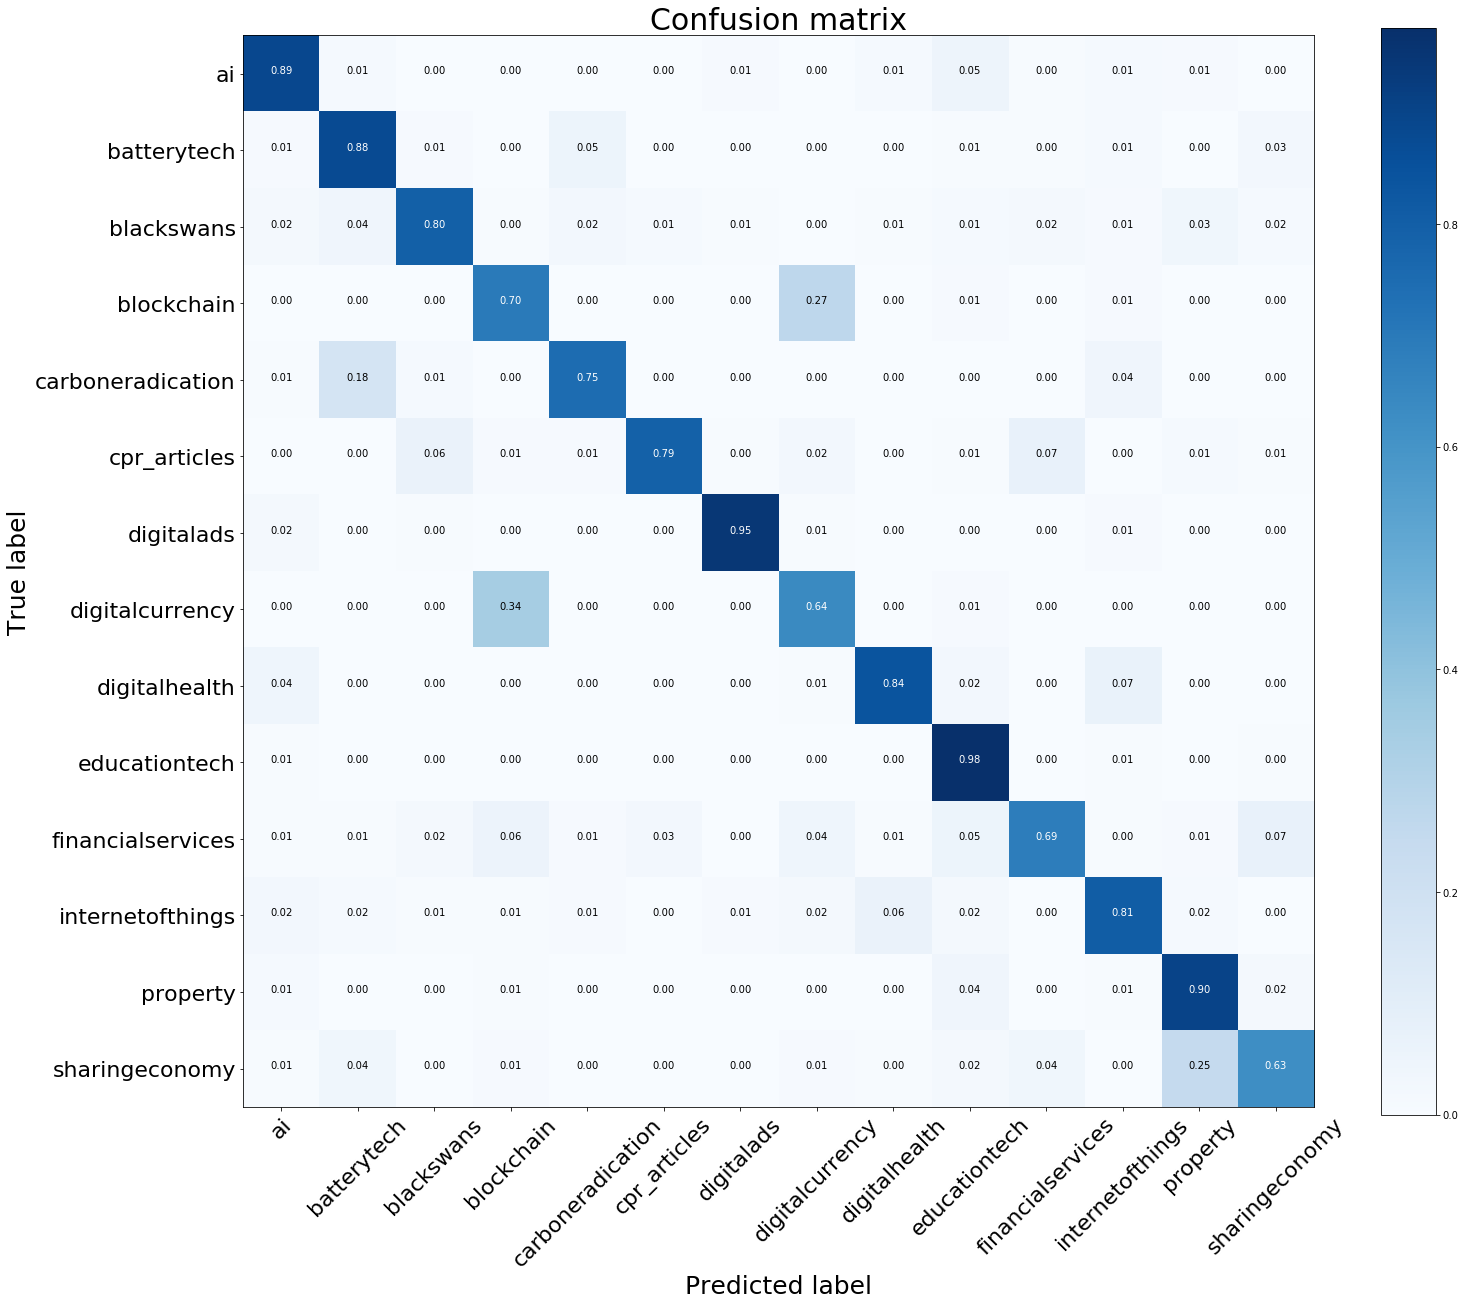

In [14]:
import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=categories, title="Confusion matrix")
plt.show()

In [16]:
# Here's how to predict a category for an individual example by tokenizing it first

number_of_text = 40000

text_to_predict = str(texts[number_of_text])
print("Text_to_predict: \n", text_to_predict)

cleantext = remove_html_tags(text_to_predict)
print("Cleaned text: \n", cleantext)

sequence = tokenizer.texts_to_sequences([cleantext])
print("Sequence: \n", sequence, "\n Sequence length: ", len(sequence), "\n")

trans_text = pad_sequences(sequence, maxlen=150)
print("Trans_text shape: ", trans_text.shape, "\n")

prediction = model.predict(np.array(trans_text))
print(prediction, "\n")

predicted_label = categories[np.argmax(prediction)]
print("Predicted Category number: ", np.argmax(prediction))
print("Predicted Category name: ", predicted_label)
print("Actual Category name: ", labels[number_of_text], "\n\n")

Text_to_predict: 
 <p>An upcoming election in Myanmar may cause a liberalisation of the country's property ownership rules, including allowing foreigners to directly own Myanmar property for the first time. Investment and activity in the market has slowed up the run-up to the election amid uncertainty, but this report suggests that after the election foreign investment could accelerate to levels not seen before in the country. The election will take place on Sunday, 8th November.</p>

Cleaned text: 
 An upcoming election in Myanmar may cause a liberalisation of the country's property ownership rules, including allowing foreigners to directly own Myanmar property for the first time. Investment and activity in the market has slowed up the run-up to the election amid uncertainty, but this report suggests that after the election foreign investment could accelerate to levels not seen before in the country. The election will take place on Sunday, 8th November.

Sequence: 
 [[24, 6, 1203, 5, 

In [18]:
# Here's how predict a series of texts

for i in range(10):
    number_of_text = i+40000

    text_to_predict = str(texts[number_of_text])
    #print("Text_to_predict: \n", text_to_predict)

    cleantext = remove_html_tags(text_to_predict)
    print("Body text: \n", cleantext)

    sequence = tokenizer.texts_to_sequences([cleantext])
    #print("Sequence: \n", sequence, "\n Sequence length: ", len(sequence), "\n")

    trans_text = pad_sequences(sequence, maxlen=150)
    #print("Trans_text shape: ", trans_text.shape, "\n")

    prediction = model.predict(np.array(trans_text))
    #print(prediction, "\n")

    predicted_label = categories[np.argmax(prediction)]
    print("Predicted Category number: ", np.argmax(prediction))
    print("Predicted Category name: ", predicted_label)
    #print("Actual Category name: ", categories[np.argmax(cleanlabels[i])], "\n\n")
    print("Actual Category name: ", labels[i+40000], "\n\n")

Body text: 
 An upcoming election in Myanmar may cause a liberalisation of the country's property ownership rules, including allowing foreigners to directly own Myanmar property for the first time. Investment and activity in the market has slowed up the run-up to the election amid uncertainty, but this report suggests that after the election foreign investment could accelerate to levels not seen before in the country. The election will take place on Sunday, 8th November.

Predicted Category number:  12
Predicted Category name:  property
Actual Category name:  property 


Body text: 
 HotelTonight, the app-based hotel booking service, has been forced to lay off 20% of its staff. The company was launched in 2011 to make booking last-minute accommodation easier, but faces competition from Google, which launched its own instant booking service this year, and TripAdvisor, which also has its own instant booking product. In the US, HotelTonight has consistently been rated in the top 20 travel